In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
import nbimporter
import random_forest_method
import performance_measure
import svm_method

/Users/mortenolsenosvik/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mortenolsenosvik/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mortenolsenosvik/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mortenolsenosvik/anaconda3/lib/python3.7/s

Importing Jupyter notebook from random_forest_method.ipynb
Importing Jupyter notebook from performance_measure.ipynb
Importing Jupyter notebook from svm_method.ipynb


### Technique of loading data and training model simultaniously (NOT IN USE)

In [2]:
#counter = 0
#for chunk in pd.read_csv(path, chunksize=1000000): #, compression='zip'):
#    counter +=1
    # Do model training here:
#    print('Reading batch {} / 52'.format(counter), end='\r')
#print('\nReading Complete!')

### Map status code to status description

In [3]:
fault_dict = {}
fault_dict['Other'] = 'Other'
fault_dict['Status_9_Substatus_8'] = 'Generator heating - (Manual)'
fault_dict['Status_62_Substatus_7'] = 'Feeding fault - (Diff. P-set/P-actual)'
fault_dict['Status_62_Substatus_30'] = 'Feeding fault - (Feeding safety circuit faulty)'
def get_description_from_status(status):
    return fault_dict[status]
    

### Method to print amount and percentage of statuses in datset

In [4]:
def get_statues_percentage(dataframe, description):
    status_count = dataframe.Status.value_counts()
    total_status_count = dataframe.shape[0]
    print('Proportion of failures in {}'.format(description))
    print('Status\t\t\t Percentage\t Amount')
    print('Other:\t\t\t {0:.3f}%\t {1}'.format(100*status_count[0]/(total_status_count), status_count[0]))
    print('Status_9_Substatus_8: \t {0:.3f} %\t {1}'.format(100*status_count[1]/(total_status_count), status_count[1]))
    print('Status_62_Substatus_7:\t {0:.3f}%\t\t {1}'.format(100*status_count[2]/(total_status_count), status_count[2]))
    print('Status_62_Substatus_30:\t {0:.3f}%\t\t {1}'.format(100*status_count[3]/(total_status_count), status_count[3]))
    print('')

### Create bar plot of amount of statuses

In [5]:
def plot_balance(dataframe, column):
    s = dataframe[column].value_counts()
    fig, ax = plt.subplots()

    # Remove the plot frame lines. They are unnecessary chartjunk.  
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  

    # Make sure your axis ticks are large enough to be easily read.  
    # You don't want your viewers squinting to read your plot.  
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)  

    plt.ylabel("Frequency of fault", fontsize=14)  
    plt.xlabel("Fault type", fontsize=14)  
    
    
    dataframe[column].value_counts().plot(ax=ax, kind='bar')
    plt.figure(figsize=(20, 16))

    #Save file
    plt.savefig('../Data_Plots/data_balance')
    

### Loading dataset without missing values

In [6]:
path = "../../../../../../XAI_Datasets/Data/all_data_filled.csv"
#'/Users⁩/mortenolsenosvik⁩/⁨XAI_Datasets⁩/Data/'
data = pd.read_csv(path)#, nrows=500000)

### Undersampling the dataset 

In [7]:
def undersample_dataset(dataset, sample_amount):
    # Extract each status
    others = dataset.loc[dataset['Status'] == 'Other']
    status_9_Substatus_8   = dataset.loc[dataset['Status'] == 'Status_9_Substatus_8']
    status_62_Substatus_7  = dataset.loc[dataset['Status'] == 'Status_62_Substatus_7']
    status_62_Substatus_30 = dataset.loc[dataset['Status'] == 'Status_62_Substatus_30']

    # undersampe the majority class ('Other')
    sampled_others = others.sample(sample_amount, random_state = 12)
    undersampled_data = pd.concat([sampled_others, status_9_Substatus_8, 
                                   status_62_Substatus_7, status_62_Substatus_30], ignore_index=True)
    undersampled_data = shuffle(undersampled_data)
    undersampled_data.reset_index(inplace=True, drop=True)

    # Save dataframe to csv
    undersampled_data.to_csv('../../../../../../XAI_Datasets/Data/undersampled_data.csv', 
                             encoding='utf-8', index=False)
    
    return(undersampled_data)


In [8]:
undersampled_data = undersample_dataset(data, 300000)
#get_statues_percentage(data, 'the unprocessed dataset')
#get_statues_percentage(undersampled_data, 'the undersampled dataset')


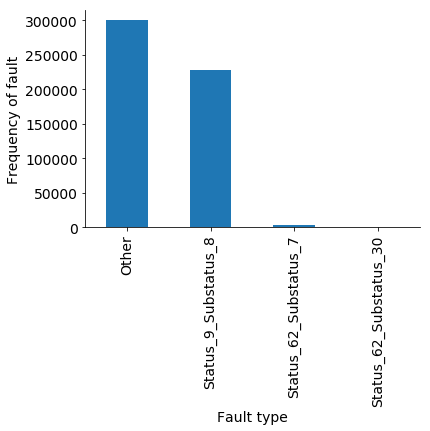

<Figure size 1440x1152 with 0 Axes>

In [9]:
plot_balance(undersampled_data, 'Status')

In [10]:
X = undersampled_data.drop(columns = ['Status', 'TimeStamp'])
y = undersampled_data.Status

In [11]:
y.value_counts()

Other                     300000
Status_9_Substatus_8      228668
Status_62_Substatus_7       4098
Status_62_Substatus_30       383
Name: Status, dtype: int64

Normalized confusion matrix
[[9.97747498e-01 4.04036323e-05 5.85852668e-04 1.62624620e-03]
 [2.61904762e-01 7.06349206e-01 0.00000000e+00 3.17460317e-02]
 [2.73668639e-02 0.00000000e+00 9.72633136e-01 0.00000000e+00]
 [3.31296961e-04 0.00000000e+00 0.00000000e+00 9.99668703e-01]]


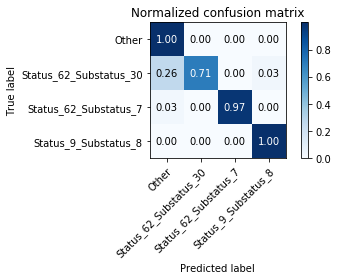

Total Accuracy 		0.998

Status 				 Precision 	 Recall 	 F1
----------------------------------------------------------------------
Other                     	 0.999 		 0.998 		 0.998
Status_62_Substatus_30    	 0.957 		 0.706 		 0.813
Status_62_Substatus_7     	 0.958 		 0.973 		 0.965
Status_9_Substatus_8      	 0.998 		 1.000 		 0.999


In [12]:
fet = random_forest_method.get_model(X, y)

In [13]:
fet

,importance
ActivePower,0.189577
Log-T-Raw-Rectifier1HeatSink,0.119387
Log-T-Raw-TransformerTemperature,0.085824
Average blade angle across A B C,0.057784
Log-T-Raw-Stator2Temperature,0.040386
Log-T-Raw-Stator1Temperature,0.037200
Log-T-Raw-NacelleAmbientTemperature,0.036596
Ambient-Temperature,0.032032
Log-T-Raw-ControlCabinetTemperature,0.030425
Log-T-Raw-TowerTemperature,0.027442


### SVM method

In [ ]:
svm_method.get_model(X, y)

Loading...
Training...


### SMOTE (Synthetic Minority Oversampling Technique):

In [ ]:
sm = SMOTE(random_state=12)
X_